The NLR7301 is a supercritical airfoil which has been modified to a two-element configuration with a non-retractable flap. This configuration and the measurements were designed for the purpose of CFD validation[1]. The measurements were taken in 1979 and includes detailed pressure distributions, transition onset locations and someboundary layer velocity profiles for the angles of attack 6° and 13.1°. These measurements have been used extensively for another viscid-inviscid interaction method[2] as well as Navier Stokes codes, e.g.[3]. There is only a single measurement set available, at a Reynolds Number of 2.51E6 and a Mach Number of .185, comprising a set of 16 lift and 3 drag values. In the following, the results of viiflow using the Integral Boundary Layer Equations and the Panel Method with a Prandtl-Glauert correction are compared to these measurements.

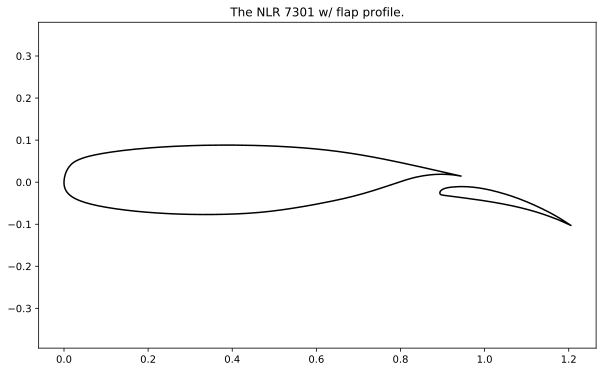

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10, 6] # Make plots bigger than default

# Read Airfoil Data
MAIN = vft.repanel_spline(vft.read_selig("NLR7301.dat"),220) #180
FLAP = vft.repanel_spline(vft.read_selig("NLR7301FLAP.dat"),180) #150

# Plot Airfoil shape
plt.plot(MAIN[0,:],MAIN[1,:],color="black")
plt.plot(FLAP[0,:],FLAP[1,:],color="black")
plt.axis('equal')
plt.title('The NLR 7301 w/ flap profile.');

## Geometry, Angle of Attack and Flap

A few notes on the measurement and the geometry are in order. The geometry of the configuration was obtained from the appendix of a thesis[4] as the geometry is not part of the experiment description.
Another source of geometrical error is the placement and angle of the flap. Below, a picture of the two source document geometries and the used geometry from the thesis are compared.

![Comparison](geocomparison.png)

*Comparison between the geometries of the two measurement publications (black) and the used geometry (blue).*


Matching the geometry with the image from the experiment looks quite good, but the angles of attack might differ from the geometry and the experiment. This shift means that the angle of attack of the experimental data is shifted by -.5°, i.e. a bit to the left. This shift is a bit larger than the margin or error seen by comparing the geometries in an image editor. There, a rotation of .3° of the data in the original document from 1979 leads to a better fit between the main airfoil shapes while rotating the flap in the used geometry by 0.2° up to 0.5° looks better in comparison to the documents.
All of this is said because the results below are compared to the untouched and to shifted results, which are matching the computations better. The discussion below will compare the shifted results (and not constantly note the better fit if the data was shifted).

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0.185 using a Prandtl-Glauert correction for the pressure and lift. Like in the S805 example a critical amplification factor of 10.2 was used, even though for the Delft low-speed wind tunnel 11.2 seems to be recommended[5]. 

In [2]:
# Settings
RE = 2.51e6
ncrit = 10.2
Mach = 0.185
s = vf.setup(RE,Mach,ncrit,0.0)
s.iterate_wakes = True # Re-calculate wake shape at every iteration
s.itermax = 20 # Iterations before returning to Python
s.silent = False # No output besides errors

# Set-up and initialize based on inviscid panel solution
[p,bl,x] = vf.init([MAIN,FLAP],s)

results = {} # Dictionary of results
valv = [0.185] # Maybe use a set of Mach numbers for comparison!
for val in valv:
    xn = x.copy()
    results[val] = {}
    results[val]["AOA"] = []
    results[val]["CL"] = []
    results[val]["CD"] = []
    s.ncrit = ncrit
    s.Ma = val
    for alpha in np.arange(0,17,.5):
        s.alpha = alpha
        res = None
        grad = None
        for it in range(5):
            [xn,flag,res,_,_,_,_,_,_,_] = vf.iter(xn,bl,p,s,res,grad)
            if np.sqrt(np.dot(res.T,res))<2e-3:
                results[val]["AOA"].append(alpha)
                results[val]["CL"].append(p.CL)
                results[val]["CD"].append(bl[0].CD[0]+bl[1].CD[0])
                break


Iteration 16, |res| 0.000737, lam 0.359825
Iteration 5, |res| 0.000824, lam 0.582725
Iteration 20, |res| 0.001085, lam 0.166667
Iteration 20, |res| 0.001285, lam 0.166667
Iteration 6, |res| 0.000583, lam 0.842465
Iteration 7, |res| 0.000616, lam 0.413079
Iteration 20, |res| 0.004695, lam 0.166667
Iteration 12, |res| 0.000968, lam 0.166667
Iteration 20, |res| 0.001060, lam 0.193290
Iteration 20, |res| 0.001217, lam 0.166667
Iteration 11, |res| 0.000838, lam 0.166667
Iteration 6, |res| 0.000567, lam 0.727982
Iteration 4, |res| 0.000456, lam 0.715226
Iteration 5, |res| 0.000960, lam 0.485020
Iteration 13, |res| 0.000837, lam 0.244388
Iteration 20, |res| 0.002186, lam 0.166667
Iteration 9, |res| 0.000873, lam 0.166667
Iteration 20, |res| 0.001792, lam 0.166667
Iteration 20, |res| 0.001474, lam 0.166667
Iteration 13, |res| 0.000947, lam 0.243673
Iteration 12, |res| 0.000742, lam 0.326160
Iteration 9, |res| 0.000980, lam 0.166667
Iteration 7, |res| 0.000819, lam 0.498554
Iteration 8, |res| 0

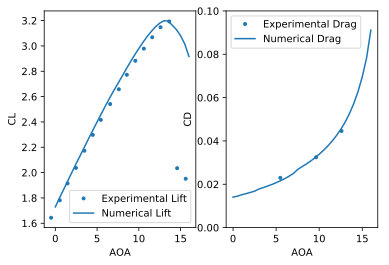

In [3]:
# Read experimental data
EXPRES=np.genfromtxt("NLRLIFTSLOPE.csv",delimiter=",",names=True)

fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['MEASSHIFT_X'],EXPRES['MEASSHIFT_Y'],marker=".",linestyle = 'None', color="tab:blue")
for val in valv:
    ax[0].plot(np.array(results[val]["AOA"]),results[val]["CL"],marker="None")
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].legend(['Experimental Lift','Numerical Lift'])

EXPRES=np.genfromtxt("NLRDRAGSLOPE.csv",delimiter=",",names=True)
ax[1].plot(EXPRES['MEASSHIFT_X'],EXPRES['MEASSHIFT_Y'],marker=".",linestyle = 'None', color="tab:blue")
for val in valv:
    ax[1].plot(results[val]["AOA"],results[val]["CD"],marker="None")
ax[1].set_xlabel('AOA')
ax[1].set_ylabel('CD')
ax[1].set_ylim([0, 0.1])
ax[1].legend(['Experimental Drag','Numerical Drag']);

[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun H. Chen. *An interactive boundary-layer method for multielement airfoils.* Computers & fluids 27.5 (1998): 651-661.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.